# Bar Learning problem

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/BarLearning.ipynb){target="_blank"} [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/master/notebooks/BarLearning.ipynb){target="_blank"}

The bar learning problem describes the process of learning receptive fields on an artificial input pattern.
Images consisting of independent bars are used. Those images are generated as following: an 8\*8 image can filled randomly by eight horizontal or vertical bars, with a probability of 1/8 for each.

These input images are fed into a neural population, whose neurons should learn to extract the independent components of the input distribution, namely single horizontal or vertical bars.


In [1]:
#!pip install ANNarchy

## Model overview

The model consists of two populations `inp` and `feature`. The size of
`inp` should be chosen to fit the input image size (here 8*8). The
number of neurons in the `feature` population should be higher than the
total number of independent bars (16, we choose here 32 neurons). The
`feature` population gets excitory connections from `inp` through an
all-to-all connection pattern. The same pattern is used for the
inhibitory connections within `feature`.

## Defining the neurons and populations

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann
ann.clear()

ANNarchy 4.8 (4.8.0) on darwin (posix).


**Input population:**

The input pattern will be clamped into this population by the main loop for every trial, so we just need an `InputArray` to store the values:

In [3]:
inp = ann.InputArray(geometry=(8, 8))

**Feature population:**

The neuron type composing this population sums up all the excitory
inputs gain from `inp` and the lateral inhibition within `feature`.

$$\tau \frac {dr_{j}^{\text{feature}}}{dt} + r_{j}^{feature} = \sum_{i} w_{ij} \cdot r_{i}^{\text{inp}}  - \sum_{k, k \ne j} w_{kj} * r_{k}^{feature}$$

could be implemented as the following:


In [4]:
LeakyNeuron = ann.Neuron(
    parameters=""" 
        tau = 10.0 : population
    """,
    equations="""
        tau * dr/dt + r = sum(exc) - sum(inh) : min=0.0
    """
)

The firing rate is restricted to positive values with the `min=0.0`
flag. The population is created in the following way:

In [5]:
feature = ann.Population(geometry=(8, 4), neuron=LeakyNeuron)

We give it a (8, 4) geometry for visualization only, it does not
influence computations at all.

## Defining the synapse and projections

Both feedforward (`inp` $\rightarrow$ `feature`) and lateral
(`feature` $\rightarrow$ `feature`) projections are learned using the
Oja learning rule (a regularized Hebbian learning rule ensuring the sum
of all weights coming to a neuron is constant). Only some parameters will
differ between the projections.

$$\tau \frac{dw_{ij}}{dt} = r_{i} \cdot r_{j} - \alpha \cdot r_{j}^{2} \cdot w_{ij}$$

where $\alpha$ is a parameter defining the strength of the
regularization, $r_i$ is the pre-synaptic firing rate and $r_j$ the
post-synaptic one. The implementation of this synapse type is
straightforward:

In [6]:
Oja = ann.Synapse(
    parameters=""" 
        tau = 2000.0 : postsynaptic
        alpha = 8.0 : postsynaptic
        min_w = 0.0 : postsynaptic
    """,
    equations="""
        tau * dw/dt = pre.r * post.r - alpha * post.r^2 * w : min=min_w
    """
)  

For this network we need to create two projections, one excitory between
the populations `inp` and `feature` and one inhibitory within the
`feature` population itself:

In [7]:
ff = ann.Projection(
    pre=inp, 
    post=feature, 
    target='exc', 
    synapse = Oja    
)
ff.connect_all_to_all(weights = ann.Uniform(-0.5, 0.5))
                     
lat = ann.Projection(
    pre=feature, 
    post=feature, 
    target='inh', 
    synapse = Oja
)
lat.connect_all_to_all(weights = ann.Uniform(0.0, 1.0))

The two projections are all-to-all and use the `Oja` synapse type. They
only differ by the parameter `alpha` (lower in `lat`) and
the fact that the weights of `ff` are allowed to be negative
(so we set the minimum value to -10.0):

In [8]:
ff.min_w = -10.0
lat.alpha = 0.3

We can now compile the network:

In [9]:
ann.compile()

Compiling ...  OK 


## Setting inputs

Once the network is defined, one has to specify how inputs are fed into
the `inp` population. A simple solution is to define a method that
sets the firing rate of `inp` according to the specified probabilities
every time it is called, and runs the simulation for 50 ms:

In [10]:
def trial():

    # Reset the firing rate for all neurons
    inp.r = 0.0

    # Clamp horizontal bars randomly
    for h in range(inp.geometry[0]):
        if np.random.random() < 1.0/ float(inp.geometry[0]):
            inp[h, :].r = 1.0

    # Clamp vertical bars randomly
    for w in range(inp.geometry[1]):
        if np.random.random() < 1.0/ float(inp.geometry[1]):
            inp[:, w].r = 1.0

    # Simulate for 50ms
    ann.simulate(50.)
    
    # Return firing rates and receptive fields for visualization
    return inp.r, feature.r, ff.receptive_fields()

One can use here a single value or a Numpy array (e.g.
`np.zeros(inp.geometry))`) to reset activity in Input, it does not matter.

For all possible horizontal bars, a decision is then made whether the
bar should appear or not, in which case the firing rate of the
correspondng neurons is set to 1.0:

```python
for h in range(inp.geometry[0]):
    if np.random.random() < 1.0/ float(inp.geometry[0]):
        inp[h, :].r = 1.0
```

`inp[h, :]` is a PopulationView, i.e. a group of neurons defined by
the sub-indices (here the row of index `h`). Their attributes, such as
`r`, can be accessed as if it were a regular population. The same is
done for vertical bars.

## Running the simulation

Let's have a look at the activities and receptive fields after one trial:

In [11]:
input_r, feature_r, weights = trial()

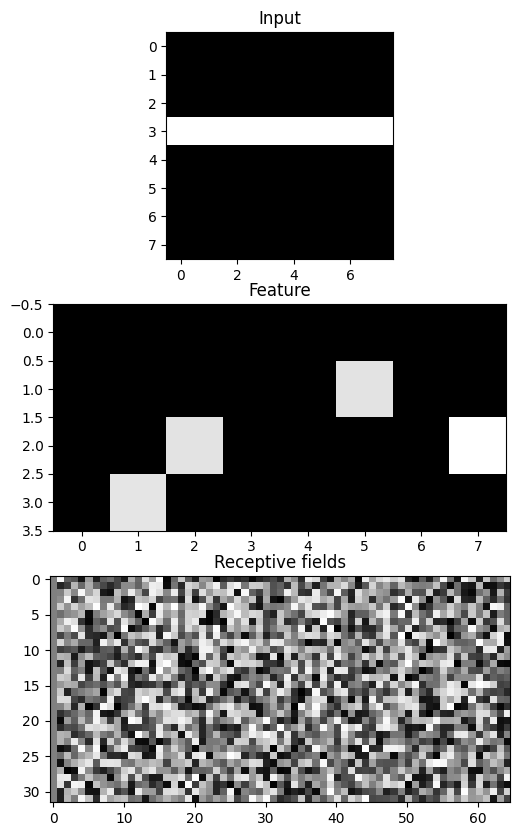

In [12]:
def plot(ax, input_r, feature_r, weights):
    ax[0].clear(); ax[1].clear(); ax[2].clear()
    ax[0].imshow(input_r.T, interpolation='nearest', cmap=plt.cm.gray)
    ax[0].set_title('Input')
    ax[1].imshow(feature_r.T, interpolation='nearest', cmap=plt.cm.gray)
    ax[1].set_title('Feature')
    ax[2].imshow(weights.T, interpolation='nearest', cmap=plt.cm.gray)
    ax[2].set_title('Receptive fields')

fig, ax = plt.subplots(3, 1, figsize=(6, 10))
plot(ax, input_r, feature_r, weights)    

One or a few bars are present in `inp`, a few neurons react in `feature`, but the receptive fields are all random. 

Let's now define a `for` loop where the `trial()` method is called repetitively:

In [13]:
inputs = []; features = []; rfs = []
for t in range(1000):
    input_r, feature_r, weights = trial()
    inputs.append(input_r); features.append(feature_r); rfs.append(weights)

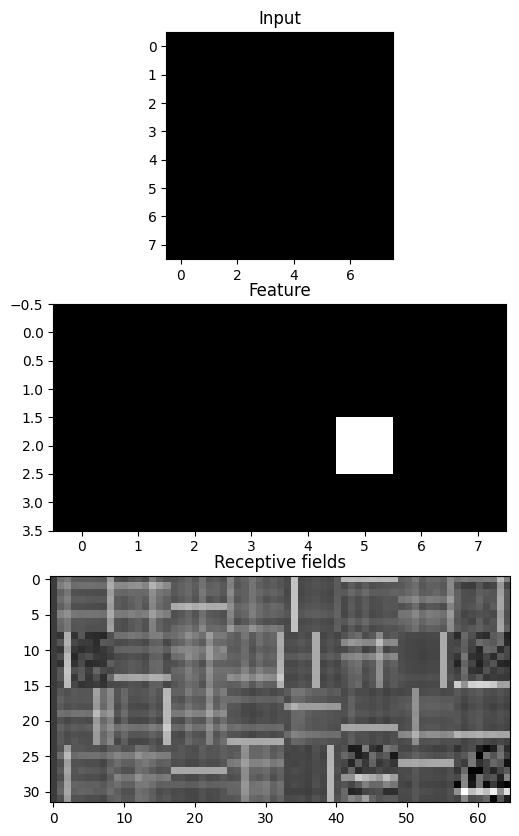

In [14]:
idx = -1 # last trial

fig, ax = plt.subplots(3, 1, figsize=(6, 10))
plot(ax, inputs[idx], features[idx], rfs[idx])  

After 1000 trials, most neurons have developed a receptive field specific for a single horizontal or vertical bar, although these were always presented together.

Several methods are possible to see what is happening during learning. The following cell uses `moviepy` (`pip install moviepy`) to create a `.mp4` movie, but feel free to experiment with other methods.

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


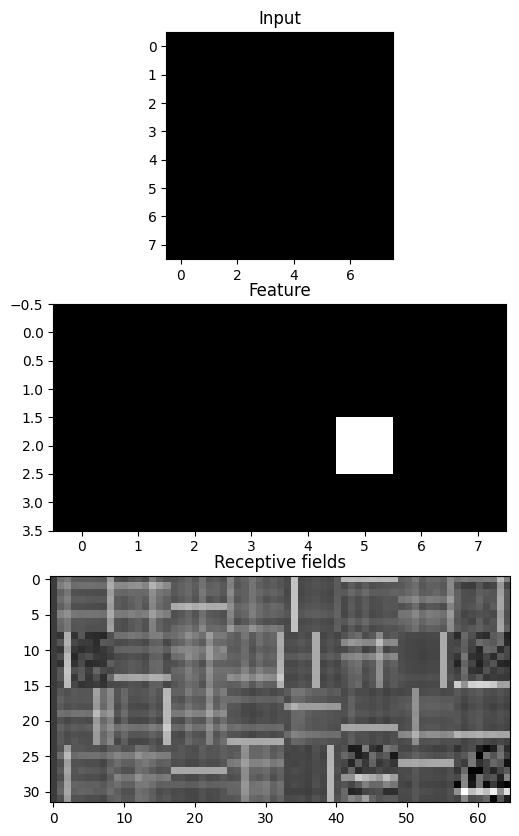

In [15]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, ax = plt.subplots(3, 1, figsize=(6, 10))
def make_frame(t):
    idx = int(20*t)
    plot(ax, inputs[idx], features[idx], rfs[idx])  
    return mplfig_to_npimage(fig)

fps=20.
animation = VideoClip(make_frame, duration=1000/fps)
animation.ipython_display(fps=fps, loop=True, autoplay=True)